Name: Chan Wei Jian Ivan

ID: 1005924

For our project, we will be pulling Bert-base-uncased from hugging face and finetuning it for predicting movie sentiment reviews using the IMDB dataset.

In [ ]:
from datasets import load_dataset, DatasetDict

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Split the training set into 80% training and 20% validation
train_testvalid = dataset["train"].train_test_split(test_size=0.2, seed=42)

# Further split the validation set into 50% validation and 50% test
valid_test = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)

# Combine splits into a DatasetDict
dataset_split = DatasetDict({
    "train": train_testvalid["train"],
    "validation": train_testvalid["test"],
    "test": dataset["test"]  # Use the original test set as-is
})

# Print the sizes of the splits
print(f"Train set: {len(dataset_split['train'])} rows")
print(f"Validation set: {len(dataset_split['validation'])} rows")
print(f"Test set: {len(dataset_split['test'])} rows")


In [1]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
dataset = load_dataset('imdb')

In [ ]:
max_input_length = tokenizer.model_max_length
print(max_input_length)

512


BERT's maximum input length is 512 tokens, however based on the histogram done in the project notebook, most of the reviews are around 250 tokens. Hence it is sufficient to truncate the reviews to 256 for predicting sentiment while reducing the amount of computation required.

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

## Apply preprocessing
tokenized_dataset = dataset_split.map(preprocess_function, batched=True)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
import torch

class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        # Extract input encodings and labels from the Dataset object
        self.encodings = {
            "input_ids": dataset["input_ids"],
            "attention_mask": dataset["attention_mask"]
        }
        self.labels = dataset["label"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Access encodings and labels for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [ ]:
train_dataset = IMDBDataset(tokenized_dataset["train"])
validation_dataset = IMDBDataset(tokenized_dataset["validation"])
test_dataset = IMDBDataset(tokenized_dataset["test"])

In [ ]:
# Save the tokenized dataset
import torch

# Save the datasets
torch.save(train_dataset, "train_dataset.pt")
torch.save(validation_dataset, "validation_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

print("Datasets saved!")


Now we load BERT from transformers

We add a classification head with a dropout layer to reduce overfitting and a fully connected layer for sentiment prediction.

Lastly, we extract the CLS token for classification. The CLS token is used to represent the sentence level classification. It contains the embedding that summarizes the sentiment of the entire sentence.

In [2]:
from transformers import AutoModel
import torch.nn as nn
import torch

class SentimentClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(SentimentClassifier, self).__init__()
        # Load pretrained BERT model
        self.bert = AutoModel.from_pretrained(pretrained_model_name)

        # Define a dropout layer
        self.dropout = nn.Dropout(0.3)

        # Define a linear layer for classification
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Pass inputs through BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        # Use the [CLS] token output
        pooled_output = outputs[1]
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        # Apply classification layer
        logits = self.classifier(pooled_output)
        return logits

# Initialize the model
model = SentimentClassifier("bert-base-uncased", num_labels=2)

# Move model to device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [6]:
from torch.optim import AdamW

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [7]:
# Load the datasets
train_dataset = torch.load("train_dataset.pt")
validation_dataset = torch.load("validation_dataset.pt")
test_dataset = torch.load("test_dataset.pt")

print("Datasets loaded!")

C:\Users\ivanc\AppData\Local\Temp\ipykernel_21108\3962022104.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load("train_dataset.pt")
C:\Users\ivan

Datasets loaded!


In [8]:
from torch.utils.data import DataLoader

# DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16)

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

epochs = 3  # Number of training epochs
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()  # Set the model to training mode
    total_loss = 0

    # Training loop
    for batch in train_loader:
        # Move data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        logits = model(input_ids, attention_mask)  # Model now directly returns logits
        loss = criterion(logits, labels)  # Compute loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

    # Log average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_loss:.4f}")

    # Validation step after each epoch
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient computation for validation
        for batch in validation_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=1)  # Get class predictions

            # Calculate accuracy
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    # Compute validation accuracy
    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the model after each epoch


    save_path = f"./sentiment_model_epoch_{epoch + 1}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved at {save_path}")

Epoch 1/3
Average Training Loss: 0.1702
Validation Accuracy: 0.9060
Model saved at ./sentiment_model_epoch_1.pt
Epoch 2/3
Average Training Loss: 0.0981
Validation Accuracy: 0.9038
Model saved at ./sentiment_model_epoch_2.pt
Epoch 3/3
Average Training Loss: 0.0642
Validation Accuracy: 0.9022
Model saved at ./sentiment_model_epoch_3.pt


Continuing to finetune the model after 3 epochs

In [ ]:
## previous training loss
training_loss = [0.1702, 0.0981, 0.0642]

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = SentimentClassifier("bert-base-uncased", num_labels=2)

# Load the previously saved model weights
checkpoint_path = "sentiment_model_epoch_3.pt"  # Path to the saved model after 3 epochs
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.to(device)

# Optimizer and criterion (define the same as before)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Resume fine-tuning
start_epoch = 3  # Last epoch completed
additional_epochs = 3  # Additional number of epochs to train
for epoch in range(start_epoch, start_epoch + additional_epochs):
    print(f"Epoch {epoch + 1}/{start_epoch + additional_epochs}")
    model.train()  # Set the model to training mode
    total_loss = 0

    # Training loop
    for batch in train_loader:
        # Move data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Log average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    training_loss.append(avg_loss)
    print(f"Average Training Loss: {avg_loss:.4f}")

    # Validation step
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the model after each epoch
    save_path = f"./sentiment_model_epoch_{epoch + 1}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved at {save_path}")


Epoch 4/6
Average Training Loss: 0.0542
Validation Accuracy: 0.8932
Model saved at ./sentiment_model_epoch_4.pt
Epoch 5/6
Average Training Loss: 0.0324
Validation Accuracy: 0.9004
Model saved at ./sentiment_model_epoch_5.pt
Epoch 6/6
Average Training Loss: 0.0322
Validation Accuracy: 0.9006
Model saved at ./sentiment_model_epoch_6.pt


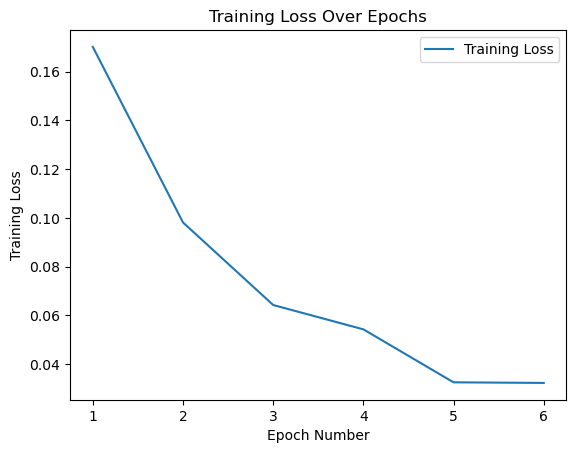

In [16]:
## plot training loss against epochs
import matplotlib.pyplot as plt

plt.plot(range(1, 7), training_loss, label="Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [20]:
from torch.utils.data import DataLoader

# DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16)

# Move the model to the appropriate device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Evaluation
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        logits = model(input_ids, attention_mask)
        predictions = torch.argmax(logits, dim=1)  # Get predicted class labels

        # Calculate accuracy
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Compute final accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9002


In [31]:
from transformers import AutoTokenizer
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
current_model = SentimentClassifier("bert-base-uncased", num_labels=2)
current_model.load_state_dict(torch.load("sentiment_model_epoch_3.pt"), weights_only=True)
current_model.to(device)

# Define the new sequence
sequence = """Julie Andrews satirically prods her own goody-two-shoes image in this overproduced musical comedy-drama, but if she approaches her role with aplomb, she's alone in doing so. Blake Edwards' film about a woman who is both music-hall entertainer and German spy during WWI doesn't know what tone to aim for, and Rock Hudson has the thankless task of playing romantic second-fiddle. Musicals had grown out of favor by 1970, and elephantine productions like "Star!" and this film really tarnished Andrews' reputation, leaving a lot of dead space in her catalogue until "The Tamarind Seed" came along. I've always thought Julie Andrews would've made a great villain or shady lady; her strong voice could really command attention, and she hits some low notes that can either be imposing or seductive. Husband/director Edwards seems to realize this, but neither he nor Julie can work up much energy within this scenario. Screenwriter William Peter Blatty isn't a good partner for Edwards, and neither man has his heart in this material. Beatty's script offers Andrews just one fabulous sequence--a striptease. *1/2 from ****"""

# Preprocess the sequence
inputs = tokenizer(sequence, return_tensors="pt", padding="max_length", truncation=True, max_length=256)

# Move tensors to the device
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# Run the model in evaluation mode
current_model.eval()
with torch.no_grad():
    logits = current_model(input_ids, attention_mask)
    predictions = torch.argmax(logits, dim=1)  # Get the predicted class (0 or 1)

# Decode the prediction
label_map = {0: "Negative", 1: "Positive"}  # Adjust based on your dataset's labels
predicted_label = label_map[predictions.item()]
print(f"Predicted Sentiment: {predicted_label}")


C:\Users\ivanc\AppData\Local\Temp\ipykernel_25160\802716415.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  current_model.load_state_dict(torch.load("sentiment_model_epo

Predicted Sentiment: Negative
